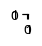

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 150
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")
import glob
from tqdm.auto import tqdm
from datetime import datetime as dt

# Load models together
from src.torch_utils import load_model_full
from src.utils import get_class_initcode_keys
from torch.utils.data import SequentialSampler
from src.datasets import *
from src.models import *
%load_ext autoreload
%autoreload 2
    
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, add_median_labels, get_palette
from src.data_processing import BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS
from src.utils import pkl_load, pkl_dump, get_palette
from src.sim_utils import make_dist_matrix
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from src.torch_utils import save_checkpoint, load_checkpoint
from src.train_eval import predict_model, train_eval_loops
from src.models import FullTCRVAE, TwoStageVAECLF
from src.metrics import get_metrics, reconstruction_accuracy, compute_cosine_distance
from src.datasets import TCRSpecificDataset, FullTCRDataset
import torch
import glob
from torch import optim
from torch.utils.data import RandomSampler, SequentialSampler
from torch import nn
from torch.nn import functional as F
mpl.rcParams['figure.dpi'] = 180


In [2]:
df = pd.read_csv('../data/filtered/240418_nettcr_expanded_20binders_17pep_POSONLY.csv')
cs = ['A1','A2','A3','B1','B2','B3']
for c in cs:
    l = df[c].apply(len)
    print(c)
    display(l.describe())

A1


count    7339.000000
mean        5.988146
std         0.571654
min         5.000000
25%         6.000000
50%         6.000000
75%         6.000000
max         7.000000
Name: A1, dtype: float64

A2


count    7339.000000
mean        6.675705
std         1.010586
min         4.000000
25%         6.000000
50%         7.000000
75%         7.000000
max         8.000000
Name: A2, dtype: float64

A3


count    7339.000000
mean       11.434528
std         2.100023
min         3.000000
25%        10.000000
50%        11.000000
75%        13.000000
max        22.000000
Name: A3, dtype: float64

B1


count    7339.000000
mean        5.080256
std         0.271708
min         5.000000
25%         5.000000
50%         5.000000
75%         5.000000
max         6.000000
Name: B1, dtype: float64

B2


count    7339.000000
mean        6.089113
std         0.322610
min         5.000000
25%         6.000000
50%         6.000000
75%         6.000000
max         7.000000
Name: B2, dtype: float64

B3


count    7339.000000
mean       12.426080
std         1.761179
min         5.000000
25%        11.000000
50%        12.000000
75%        13.000000
max        23.000000
Name: B3, dtype: float64

# triplet error

In [70]:
input1 = torch.randn(100, 128)
input2 = torch.randn(100, 128)
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
output = cos(input1, input2)

In [219]:
distances = pkl_load('/Users/riwa/Documents/code/total_dis.pkl')
pos_dis = pkl_load('/Users/riwa/Documents/code/pos_dis.pkl')
pos_mask = pkl_load('/Users/riwa/Documents/code/pos_mask.pkl')
neg_dis = pkl_load('/Users/riwa/Documents/code/neg_dis.pkl')
neg_mask = pkl_load('/Users/riwa/Documents/code/neg_mask.pkl')
labels = pkl_load('/Users/riwa/Documents/code/labels.pkl')
loss = pkl_load('/Users/riwa/Documents/code/loss.pkl')

In [220]:
diag_mask = torch.ones_like(pos_mask).fill_diagonal_(0)
mask_loss = torch.mul(loss, diag_mask)

In [ ]:
import pickle

with open('/Users/riwa/Documents/code/pos_dis.pkl', 'wb') as f:
    pickle.dump(positive_distances, f)

with open('/Users/riwa/Documents/code/neg_dis.pkl', 'wb') as f:
    pickle.dump(negative_distances, f)
    
with open('/Users/riwa/Documents/code/pos_mask.pkl', 'wb') as f:
    pickle.dump(mask_positive, f)
    
with open('/Users/riwa/Documents/code/neg_mask.pkl', 'wb') as f:
    pickle.dump(mask_negative, f)

with open('/Users/riwa/Documents/code/labels.pkl', 'wb') as f:
    pickle.dump(labels, f)

with open('/Users/riwa/Documents/code/loss.pkl', 'wb') as f:
    pickle.dump(loss, f)

with open('/Users/riwa/Documents/code/total_dis.pkl', 'wb') as f:
    pickle.dump(pairwise_distances, f)

In [221]:
# loss = F.relu(pos - neg + 0.1)
def get_vector(loss, pos, neg, i, margin=0.1):
    where = torch.where(loss[i]>0)[0]
    pp = pos[i][where]
    nn = neg[i][where]
    ll = loss[i][where]
    print('pos\n\t', pp)
    print('neg\n\t', nn)
    print('loss\n\t', ll)
    print('minus\n\t', pp-nn+margin)
    print('final loss\n\t', F.relu(pp-nn+margin))
    print('where\n\t', where)
    return pp, nn, ll

In [235]:
(labels==11).float().sum()

tensor(12.)

In [258]:
pp,nn,ll = get_vector(mask_loss, pos_dis, neg_dis, 251, margin = 0.6)

pos
	 tensor([0.4451, 1.2796, 0.0000, 1.3656, 0.0000, 0.8558],
       grad_fn=<IndexBackward0>)
neg
	 tensor([0.0000, 0.0000, 0.0897, 0.0000, 0.0905, 0.0000],
       grad_fn=<IndexBackward0>)
loss
	 tensor([0.5451, 1.3796, 0.0103, 1.4656, 0.0095, 0.9558],
       grad_fn=<IndexBackward0>)
minus
	 tensor([1.0451, 1.8796, 0.5103, 1.9656, 0.5095, 1.4558],
       grad_fn=<AddBackward0>)
final loss
	 tensor([1.0451, 1.8796, 0.5103, 1.9656, 0.5095, 1.4558],
       grad_fn=<ReluBackward0>)
where
	 tensor([ 68, 273, 338, 392, 422, 510])


In [253]:
margin=0.4452
pp-nn+margin, F.relu(pp - nn + margin)

(tensor([0.8903, 1.7248, 0.3555, 1.8108, 0.3547, 1.3010],
        grad_fn=<AddBackward0>),
 tensor([0.8903, 1.7248, 0.3555, 1.8108, 0.3547, 1.3010],
        grad_fn=<ReluBackward0>))

In [139]:
class_matrix = labels.view(-1,1)
positive_mask = (class_matrix == class_matrix.t()).float()
negative_mask = (class_matrix != class_matrix.t()).float()

# Make diagonal elements zero in positive mask since an anchor shouldn't select itself
positive_mask.fill_diagonal_(0)
positive_mask, negative_mask

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([[0., 1., 1.,  ..., 1., 1., 1.],
         [1., 0., 1.,  ..., 1., 1., 1.],
         [1., 1., 0.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 0., 1., 1.],
         [1., 1., 1.,  ..., 1., 0., 1.],
         [1., 1., 1.,  ..., 1., 1., 0.]]))

In [160]:
positive_distances = distances * positive_mask
hardest_positive_distances = positive_distances.max(dim=1)[0]

In [163]:
positive_distances[0, [129,245,341]]

tensor([1.1594, 0.9830, 1.0951], grad_fn=<IndexBackward0>)

In [162]:
torch.where(positive_distances>0)

(tensor([  0,   0,   0,  ..., 470, 470, 470]),
 tensor([129, 245, 341,  ..., 354, 379, 428]))

In [164]:
negative_distances = distances * negative_mask
# Replace zero with large number where negative_mask is zero
max_distance = distances.max().item() + 1
negative_distances += max_distance * (1 - negative_mask)
hardest_negative_distances = negative_distances.min(dim=1)[0]

In [172]:
triplet_loss = hardest_positive_distances - hardest_negative_distances + 0.1
triplet_loss = F.relu(triplet_loss)
valid_triplets = (positive_mask.sum(dim=1) > 0) & (negative_mask.sum(dim=1) > 0)


In [180]:
positive_mask[253]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [179]:
torch.where(valid_triplets==False)

(tensor([253]),)

In [166]:
negative_distances

tensor([[2.5964, 1.1194, 1.2056,  ..., 0.5992, 0.7681, 1.0439],
        [1.1194, 2.5964, 1.2990,  ..., 1.3319, 1.0508, 0.8547],
        [1.2056, 1.2990, 2.5964,  ..., 1.1263, 1.1149, 0.8849],
        ...,
        [0.5992, 1.3319, 1.1263,  ..., 2.5964, 0.9528, 0.9223],
        [0.7681, 1.0508, 1.1149,  ..., 0.9528, 2.5964, 1.1386],
        [1.0439, 0.8547, 0.8849,  ..., 0.9223, 1.1386, 2.5964]],
       grad_fn=<AddBackward0>)

In [165]:
max_distance

2.5963759422302246

# tests architectures

In [3]:
# 5k datapoints, len 50, 20 aa dim
x = torch.rand(1000, 50, 20)

In [4]:
x.permute(0,2,1).shape

torch.Size([1000, 20, 50])

In [17]:
# Taking 5 n_hidden
conv1 = nn.Conv1d(20, 10, kernel_size=5, stride=1)
mp = nn.MaxPool1d(kernel_size=4, stride=2)
conv2 = nn.Conv1d(10, 20, kernel_size=5, stride=1)

z = conv1(x.permute(0,2,1))
print(z.shape)
z = mp(z)
print(z.shape)
z = conv2(z)
print(z.shape)

torch.Size([1000, 10, 46])
torch.Size([1000, 10, 22])
torch.Size([1000, 20, 18])


In [ ]:
class CNNEncoder(nn.Module):
    def __init__(self, n_features, hidden_dim, latent_dim, kernel_size):
        super(CNNEncoder, self).__init__()
        


In [6]:
import torch
from torch import nn

class CNNEncoder(nn.Module):
    def __init__(self, L, num_features, hidden_dims, latent_dim):
        super(CNNEncoder, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv1d(num_features, hidden_dims, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2, stride=2),
            nn.Conv1d(hidden_dims, hidden_dims * 2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2, stride=2)
        )
        self.flatten = nn.Flatten()
        self.fc_mu = nn.Linear(hidden_dims * 2 * (L // 4), latent_dim)  # Adjust size accordingly
        self.fc_var = nn.Linear(hidden_dims * 2 * (L // 4), latent_dim)  # Adjust size accordingly

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Adjusting dimensions to (N, C, L)
        x = self.conv_layers(x)
        x = self.flatten(x)
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var

class CNNDecoder(nn.Module):
    def __init__(self, L, num_features, hidden_dims, latent_dim):
        super(CNNDecoder, self).__init__()
        self.fc = nn.Linear(latent_dim, hidden_dims * 2 * (L // 4))  # Adjust size accordingly
        self.conv_transpose_layers = nn.Sequential(
            nn.ConvTranspose1d(hidden_dims * 2, hidden_dims, kernel_size=6, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(hidden_dims, num_features, kernel_size=6, stride=2, padding=1),
            nn.ReLU()
        )
        self.hidden_dims = hidden_dims
        self.L = L

    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, self.hidden_dims * 2, self.L // 4)  # Reshape to (N, C, L) for ConvTranspose
        x = self.conv_transpose_layers(x)
        x = x.permute(0, 2, 1)  # Reshaping back to (N, L, C)
        return x

class VAE(nn.Module):
    def __init__(self, L=60, num_features=20, hidden_dims=128, latent_dim=64):
        super(VAE, self).__init__()
        self.encoder = CNNEncoder(L, num_features, hidden_dims, latent_dim)
        self.decoder = CNNDecoder(L, num_features, hidden_dims, latent_dim)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.reparameterize(mu, log_var)
        x_recon = self.decoder(z)
        return x_recon, mu, log_var

L = 60
aa_dim = 20
x = torch.rand(1000, L, aa_dim)
v = VAE(L, aa_dim, 128, 64)
x_hat, mu, logvar = v(x)

x.shape, x_hat.shape, mu.shape, logvar.shape

(torch.Size([1000, 60, 20]),
 torch.Size([1000, 66, 20]),
 torch.Size([1000, 64]),
 torch.Size([1000, 64]))

In [19]:
aa_dim, L = 20, 7+8+22+6+7+23

ks_in = 6
stride_in = 2
pad_in = 2

hidden = 64
latent = 32

ks_out = 3
stride_out = 5
pad_out = 4

in_conv = nn.Sequential(nn.Conv1d(aa_dim, hidden, kernel_size=ks_in, stride=stride_in, padding=pad_in),
                        nn.Conv1d(hidden, hidden * 2, ks_in, stride_in, pad_in))
x = torch.randn([100, L, aa_dim])
z = torch.randn([100, latent])

out_fc = nn.Linear(latent, hidden * 2 * (L // 4))
out_conv1 = nn.ConvTranspose1d(hidden * 2, hidden, kernel_size=ks_out, stride=stride_out, padding=pad_out)
out_conv2 = nn.ConvTranspose1d(hidden, aa_dim, kernel_size=ks_out, stride=1, padding=1)

after_in = in_conv(x.permute(0,2,1))
print('After in conv', after_in.shape)

after_out = out_fc(z)
after_out = after_out.view(-1, hidden * 2, L //4)
print('After out_fcz', after_out.shape)

after_out = out_conv1(after_out)
print('after out_conv1', after_out.permute(0, 2, 1).shape)
after_out = out_conv2(after_out).permute(0, 2, 1)

x.shape, after_out.shape

After in conv torch.Size([100, 128, 18])
After out_fcz torch.Size([100, 128, 18])
after out_conv1 torch.Size([100, 80, 64])


(torch.Size([100, 73, 20]), torch.Size([100, 80, 20]))

In [62]:
input_size = 12
((input_size-1)*stride_out)+ks_out-2*pad_out

50

In [18]:
nn.Linear(latent, hidden * 2 * (50//4))(z).shape

torch.Size([100, 1536])

In [15]:
after_in.flatten(start_dim=1).shape

torch.Size([100, 1536])

In [63]:
class CNNEncoder(nn.Module):
    def __init__(self, L, num_features, hidden_dims, latent_dim):
        super(CNNEncoder, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv1d(num_features, hidden_dims, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv1d(hidden_dims, hidden_dims * 2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
        self.flatten = nn.Flatten()
        self.fc_mu = nn.Linear(hidden_dims * 2 * (L // 4), latent_dim)  # Adjust size accordingly
        self.fc_var = nn.Linear(hidden_dims * 2 * (L // 4), latent_dim)  # Adjust size accordingly

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Adjusting dimensions to (N, C, L)
        x = self.conv_layers(x)
        x = self.flatten(x)
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var
        return x
        
class CNNDecoder(nn.Module):
    def __init__(self, L, num_features, hidden_dims, latent_dim):
        super(CNNDecoder, self).__init__()
        self.fc = nn.Linear(latent_dim, hidden_dims * 2 * (L // 4))  # Adjust size accordingly
        self.conv_transpose_layers = nn.Sequential(
            nn.ConvTranspose1d(hidden_dims * 2, hidden_dims, kernel_size=6, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(hidden_dims, num_features, kernel_size=6, stride=2, padding=1),
            nn.ReLU()
        )
        self.hidden_dims = hidden_dims
        self.L = L

    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, self.hidden_dims * 2, self.L // 4)  # Reshape to (N, C, L) for ConvTranspose
        x = self.conv_transpose_layers(x)
        x = x.permute(0, 2, 1)  # Reshaping back to (N, L, C)


x = torch.rand(1000, 50, 20)
v = VAE(50, 20, 128, 64)
x_hat, mu, logvar = v(x)

x.shape, x_hat.shape, mu.shape, logvar.shape

SyntaxError: non-default argument follows default argument (1959391978.py, line 2)

In [163]:
after_in.permute(0,2,1).shape

torch.Size([100, 4, 256])

In [161]:
L = 7+8+22+6+7+23
aa = 20
latent = 128
hidden = 128

x = torch.rand(100, L, aa)

kernel_in = 9
stride_in = 4
pad_in = 2
in_conv = nn.Sequential(nn.Conv1d(aa, hidden, kernel_in, stride_in, pad_in), # no activation here just for the dimensions
                        nn.Conv1d(hidden, hidden*2, kernel_in, stride_in, pad_in))
# simplified with dilation term==1
L_int = 1+((L + 2*pad_in - (kernel_in))/stride_in)
L_out = int(1+((L_int + 2*pad_in - (kernel_in))/stride_in))

# Conv layer and flatten
after_in = in_conv(x.permute(0,2,1))
after_flat = after_in.flatten(start_dim=1)
print('L out', 'after in, after flat\n\t', L_int, L_out, '\n\t', after_in.shape, after_flat.shape)
# Z layer
fc_mu = nn.Linear(L_out*2*hidden, latent)
z = fc_mu(after_flat)
print('z shape\n\t', z.shape)
# fc out before convtranspose
fc_out = nn.Linear(latent, L_out*2*hidden)
reconv = fc_out(z)
reconv_reshaped = reconv.view(-1, hidden*2, L_out)
print('reconv reshaped\n\t',reconv_reshaped.shape)

kernel_out_1 = 9
kernel_out_2 = 9
stride_out = 4
pad_out = 2
output_padding_1 = 1
output_padding_2 = 0
transconv = nn.Sequential(nn.ConvTranspose1d(hidden * 2, hidden, kernel_out_1, stride_out, pad_out, output_padding_1),
                          nn.ConvTranspose1d(hidden, aa, kernel_out_2, stride_out, pad_out, output_padding_2))
L_int_trans = stride_out * (L_out -1) + kernel_out_1 - (2*pad_out) + output_padding_1
L_out_trans = stride_out * (L_int_trans -1) + kernel_out_2 - (2*pad_out) + output_padding_2

after_out = transconv(reconv_reshaped).permute(0,2,1)
print('transOut, out, x\n\t', L_out_trans, '\n\t', after_out.shape, x.shape)

L out after in, after flat
	 18.0 4 
	 torch.Size([100, 256, 4]) torch.Size([100, 1024])
z shape
	 torch.Size([100, 128])
reconv reshaped
	 torch.Size([100, 256, 4])
transOut, out, x
	 73 
	 torch.Size([100, 73, 20]) torch.Size([100, 73, 20])


In [ ]:
class CNNEncoder(NetParent):
    

In [ ]:
# Will have to re-figure out the dimensions but try this one ...

In [ ]:
L_int_trans = stride_out * (L_out -1) + kernel_out - (2*pad_out) + 0
L_out_trans = stride_out * (L_int_trans -1) + kernel_out - (2*pad_out) + 0

## dataset

In [60]:
# Make a mock DF to have more data for training
mock_df = pd.concat([pd.read_csv('../data/multimodal/240311_immrepnegs_tcrs.csv'),
                     pd.read_csv('../data/multimodal/240311_nettcr_pairedAB_expanded_noswap.csv')])
mock_df.reset_index(inplace=True, drop=True)
rand_idx = torch.randperm(len(mock_df))
train_idx = rand_idx[:int(.8*len(mock_df))]
valid_idx = rand_idx[len(train_idx):]
mock_df.loc[train_idx]['partition'] = 1
mock_df.loc[valid_idx]['partition'] = 0

In [62]:
for q in ['A1','A2','A3','B1','B2','B3']:
    print(mock_df[q].apply(len).max())

7
8
22
6
7
23


In [63]:
mock_df.to_csv('../data/filtered/240515_mock_df.csv', index=False)

# class tests

In [165]:
from src.data_processing import encoding_matrix_dict
from src.models import NetParent

In [195]:

class CNNEncoder(NetParent):
    def __init__(self, kernel_size, stride, pad, max_len, features_dim,
                 activation=nn.SELU(), hidden_dim=128, latent_dim=128, batchnorm=True):
        super(CNNEncoder, self).__init__()
        self.features_dim = features_dim
        self.max_len = max_len
        self.len_in = 1 + ((1 + ((max_len + 2 * pad - kernel_size) // stride) + 2 * pad - kernel_size) // stride)
        # Neural network params
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        bn = nn.BatchNorm1d if batchnorm else nn.Identity
        self.conv_layers = nn.Sequential(nn.Conv1d(features_dim, hidden_dim, kernel_size, stride, pad),
                                         activation, bn(hidden_dim),
                                         nn.Conv1d(hidden_dim, hidden_dim * 2, kernel_size, stride, pad),
                                         activation, bn(hidden_dim*2))
        self.fc_mu = nn.Linear(self.len_in * 2 * hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.len_in * 2 * hidden_dim, latent_dim)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        mu_logvar = self.conv_layers(x)
        mu_logvar = mu_logvar.flatten(start_dim=1)
        mu = self.fc_mu(mu_logvar)
        logvar = self.fc_logvar(mu_logvar)
        return mu, logvar


class CNNDecoder(NetParent):
    def __init__(self, kernel_size, stride, pad, len_in, features_dim, output_padding_1, output_padding_2,
                 activation=nn.SELU(), hidden_dim=128, latent_dim=128, batchnorm=True):
        super(CNNDecoder, self).__init__()
        self.features_dim = features_dim
        self.len_in = len_in  # Should be the len_out of CNNEncoder
        self.len_out_trans = stride * (stride * (len_in - 1) + kernel_size - 2 * pad + output_padding_1 - 1) + kernel_size - 2 * pad + output_padding_2
        # Neural network params
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        bn = nn.BatchNorm1d if batchnorm else nn.Identity
        print(bn, hidden_dim, kernel_size, stride, pad, output_padding_1, output_padding_2, activation)
        self.conv_transpose_layers = nn.Sequential(nn.ConvTranspose1d(hidden*2, hidden, kernel_out, stride_out, pad_out, output_padding_1), nn.SELU(), bn(hidden),
                                                   nn.ConvTranspose1d(hidden, features_dim, kernel_out, stride_out, pad_out, output_padding_2), nn.SELU(), bn(features_dim))
        self.fc_z = nn.Linear(latent_dim, len_in * 2 * hidden_dim)

    def forward(self, z):
        x_hat = self.fc_z(z)
        x_hat = x_hat.view(-1, self.hidden_dim * 2, self.len_in)
        x_hat = self.conv_transpose_layers(x_hat)
        x_hat = x_hat.permute(0, 2, 1)
        return x_hat


class CNNVAE(NetParent):
    def __init__(self,
                 kernel_size_in, stride_in, pad_in,
                 kernel_size_trans, stride_trans, pad_trans, output_padding_trans_1, output_padding_trans_2,
                 max_len_a1=7, max_len_a2=8, max_len_a3=22, max_len_b1=6, max_len_b2=7, max_len_b3=23,
                 encoding='BL50LO', pad_scale=-20, aa_dim=20, add_positional_encoding=True,
                 activation=nn.SELU(), hidden_dim=128, latent_dim=128, batchnorm=True):
        super(CNNVAE, self).__init__()
        # Init params that will be needed at some point for reconstruction
        # Here, define aa_dim and pos_dim ; pos_dim is the dimension of a positional encoding.
        # pos_dim should be given by how many sequences are used, i.e. how many max_len_x > 0
        # But also use a flag `add_positional_encoding` to make it more explicit that it's active or not
        max_len = sum([max_len_a1, max_len_a2, max_len_a3, max_len_b1, max_len_b2, max_len_b3])
        pos_dim = sum([int(mlx) > 0 for mlx in
                       [max_len_a1, max_len_a2, max_len_a3, max_len_b1, max_len_b2, max_len_b3]]) \
            if add_positional_encoding else 0
        self.aa_dim = aa_dim
        self.pos_dim = pos_dim
        self.add_positional_encoding = add_positional_encoding
        features_dim = aa_dim + pos_dim
        input_dim = max_len * features_dim
        self.input_dim = input_dim
        self.features_dim = features_dim
        self.max_len = max_len
        self.encoding = encoding
        if pad_scale is None:
            self.pad_scale = -20 if encoding in ['BL50LO', 'BL62LO'] else 0
        else:
            self.pad_scale = pad_scale

        # TODO : Maybe should use -1 instead of -20 for pad values since that's the value for X in BL50LO ?
        # Create the encoding matrix to recover / rebuild sequences
        MATRIX_VALUES = deepcopy(encoding_matrix_dict[encoding])
        MATRIX_VALUES['X'] = np.array([self.pad_scale]).repeat(20)
        self.MATRIX_VALUES = torch.from_numpy(np.stack(list(MATRIX_VALUES.values()), axis=0))
        # Neural network params
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.batchnorm = batchnorm
        self.len_in = 1 + ((1 + (
                (max_len + 2 * pad_in - kernel_size_in) // stride_in) + 2 * pad_in - kernel_size_in) // stride_in)
        self.len_out = stride_trans * (stride_trans * (
                self.len_in - 1) + kernel_size_trans - 2 * pad_trans + output_padding_trans_1 - 1) + kernel_size_trans - 2 * pad_trans + output_padding_trans_2

        self.encoder = CNNEncoder(kernel_size_in, stride_in, pad_in, max_len, features_dim, activation,
                                  hidden_dim, latent_dim, batchnorm)
        self.decoder = CNNDecoder(kernel_size_trans, stride_trans, pad_trans, self.len_in, features_dim,
                                  output_padding_trans_1, output_padding_trans_2, activation, hidden_dim, latent_dim,
                                  batchnorm)

    # VAE functions (fwd, embed, reparam, etc)
    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterise(mu, logvar)
        x_hat = self.decoder(z)
        return x_hat, mu, logvar

    def embed(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterise(mu, logvar)
        return z

    def reparameterise(self, mu, logvar):
        # During training, the reparameterisation leads to z = mu + std * eps
        # During evaluation, the trick is disabled and z = mu
        if self.training:
            std = torch.exp(0.5 * logvar)
            epsilon = torch.empty_like(mu).normal_(mean=0, std=1)
            return (epsilon * std) + mu
        else:
            return mu

    def sample_latent(self, n_samples):
        z = torch.randn((n_samples, self.latent_dim)).to(device=self.encoder[0].weight.device)
        return z

    # Reshaping / reconstruction functions
    def slice_x(self, x):
        """
        Slices and extracts // reshapes the sequence vector
        Also extracts the positional encoding vector if used (?)
        Args:
            x:

        Returns:

        """
        # Here this function exists for compatibility reason
        # In theory the CNN should reconstruct the sequence in the right dimension and require no slicing - reshaping
        # We only slice to extract the sequence and positional encoding if it exists
        sequence = x
        positional_encoding = None
        # Then, if self.pos_dim is not 0, further slice the tensor to recover each part
        if self.add_positional_encoding:
            positional_encoding = sequence[:, :, self.aa_dim:]
            sequence = sequence[:, :, :self.aa_dim]
        return sequence, positional_encoding

    def recover_indices(self, seq_tensor):
        N, max_len = seq_tensor.shape[0], seq_tensor.shape[1]

        # Expand MATRIX_VALUES to have the same shape as x_seq for broadcasting
        expanded_MATRIX_VALUES = self.MATRIX_VALUES.unsqueeze(0).expand(N, -1, -1, -1)
        # Compute the absolute differences
        abs_diff = torch.abs(seq_tensor.unsqueeze(2) - expanded_MATRIX_VALUES)
        # Sum along the last dimension (20) to get the absolute differences for each character
        abs_diff_sum = abs_diff.sum(dim=-1)

        # Find the argmin along the character dimension (21)
        argmin_indices = torch.argmin(abs_diff_sum, dim=-1)
        return argmin_indices

    def recover_sequences_blosum(self, seq_tensor, AA_KEYS='ARNDCQEGHILKMFPSTWYVX'):
        return [''.join([AA_KEYS[y] for y in x]) for x in self.recover_indices(seq_tensor)]

    def reconstruct_hat(self, x_hat):
        sequence, positional_encoding = self.slice_x(x_hat)
        seq_idx = self.recover_indices(sequence)
        return seq_idx, positional_encoding

In [197]:
cnnvae = CNNVAE(kernel_in, stride_in, pad_in, kernel_out, stride_out, pad_out, output_padding_1, output_padding_2,
                7,8,22,6,7,23, 'BL50LO', -20, 20, True, nn.SELU(), 128, 128, True)
x = torch.randn(100, 7+8+22+6+7+23, 26)
x_out, mu, logvar = cnnvae(x)

<class 'torch.nn.modules.batchnorm.BatchNorm1d'> 128 9 4 2 1 0 SELU()


In [199]:
del CNNVAE

In [203]:
from src.conv_models import CNNVAE

cnnvae = CNNVAE(kernel_in, stride_in, pad_in, kernel_out, stride_out, pad_out, output_padding_1, output_padding_2,
                7,8,22,6,7,23, 'BL50LO', -20, 20, True, nn.SELU(), 128, 128, True)
x = torch.randn(100, 7+8+22+6+7+23, 26)
x_out, mu, logvar = cnnvae(x)
x.shape, x_out.shape, mu.shape, logvar.shape

<class 'torch.nn.modules.batchnorm.BatchNorm1d'> 128 9 4 2 1 0 SELU()


(torch.Size([100, 73, 26]),
 torch.Size([100, 73, 26]),
 torch.Size([100, 128]),
 torch.Size([100, 128]))

In [216]:
from src.datasets import TCRSpecificDataset
dataset = TCRSpecificDataset(mock_df, 7,8,22,6,7,23, add_positional_encoding=True, conv=True)
loader = dataset.get_dataloader(1024, sampler=SequentialSampler)

In [217]:
dataset.x.shape

torch.Size([24887, 73, 26])

In [221]:
for x, labels in loader:
    x_out, mu, logvar = cnnvae(x)
    break

In [222]:
x_out.shape, mu.shape, logvar.shape

(torch.Size([1024, 73, 26]), torch.Size([1024, 128]), torch.Size([1024, 128]))